In [3]:
df_loaded.head()

,nome_munic,datahora,casos_novos
0,Adamantina,2020-02-25,0
1,Adolfo,2020-02-25,0
2,Aguaí,2020-02-25,0
3,Águas da Prata,2020-02-25,0
4,Águas de Lindóia,2020-02-25,0


In [4]:
df_filtered = df_loaded[df_loaded.nome_munic=='Indaiatuba']
df_cases = df_filtered[:]['casos_novos'].values.astype('float32')
df_cases

array([  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   2.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,
         0.,   0.,   1.,   0.,   0.,   0.,   0.,   2.,   3.,   0.,   0.,
         0.,   0.,   0.,   4.,   1.,   0.,   0.,   2.,   6.,   2.,   1.,
         3.,   0.,   0.,   0.,   2.,   3.,   2.,   0.,   1.,   0.,   0.,
         3.,   3.,   1.,   1.,  13.,   0.,   1.,   6.,   1.,  14.,  15.,
         3.,   3.,   0.,   2.,   1.,  14.,  10.,   1.,   2.,  16.,   5.,
         4.,   3.,   7.,  14.,   3.,   0.,   3.,   3.,   4.,   1.,   4.,
         2.,   2.,   5.,   0.,   3.,  78.,  30.,   1.,   0.,  49.,  30.,
        36.,  52.,  40.,   9.,   1.,  53.,  39.,  59.,  57.,   0.,   4.,
         5.,  20.,  21.,  12.,  10.,  12.,   2.,   4.,  18.,  16.,  32.,
        22.,   3.,   2.,   5.,  18.,  20.,  14.,  5

In [14]:
df_filtered[:][-20:]

,nome_munic,datahora,casos_novos
370147,São Paulo,2021-09-20,77
370792,São Paulo,2021-09-21,391
371437,São Paulo,2021-09-22,340
372082,São Paulo,2021-09-23,294
372727,São Paulo,2021-09-24,408
373372,São Paulo,2021-09-25,238
374017,São Paulo,2021-09-26,94
374662,São Paulo,2021-09-27,60
375307,São Paulo,2021-09-28,451
375952,São Paulo,2021-09-29,232


In [1]:
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.callbacks import LambdaCallback, ModelCheckpoint,ReduceLROnPlateau
from tensorflow.keras.layers import Dense, LSTM, Dropout, Activation, GRU
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import numpy as np
import math
import os
import pandas as pd

url_repo = 'https://raw.githubusercontent.com/seade-R/dados-covid-sp/master/data/dados_covid_sp.csv'
#url_repo = 'dados_covid_sp.csv'
df_loaded = pd.read_csv(url_repo, delimiter=';', usecols=['nome_munic','casos_novos','datahora'])
data = {'city':'São Paulo'}
df_filtered = df_loaded[df_loaded.nome_munic==data['city']]

def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back):
        dataX.append(dataset[i:(i+look_back), 0])
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)
df_cases = df_filtered[:]['casos_novos'].values.astype('float32')
df_cases = df_cases.reshape(len(df_cases),1)

scaler = MinMaxScaler(feature_range=(0, 1))
df_cases = scaler.fit_transform(df_cases)


In [2]:
train_size = int(len(df_cases) * 0.8)
test_size = len(df_cases) - train_size
train, test = df_cases[0:train_size, :], df_cases[train_size:len(df_cases)+1, :]
print(len(train), len(test))

474 119


In [3]:
look_back = 7
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [4]:
from tensorflow.keras.optimizers import SGD

hidden_nodes = int(2/3 * look_back)
model = Sequential()
model.add(LSTM(128, input_shape=(1, look_back)))
model.add(Dropout(0.055))
# model.add(LSTM(64, input_shape=(1, look_back)))
model.add(Dense(256))
#model.add(Dense(1, activation='tanh'))
model.add(Dense(1, activation='tanh'))
opt=SGD(learning_rate=0.001, momentum=0.9)
model.compile(loss='mean_absolute_error', optimizer=opt, metrics=['mae'])

history = model.fit(trainX, trainY, validation_data=(testX, testY), epochs=60, batch_size=2, verbose=1)

Epoch 1/60
234/234 [==============================] - 2s 4ms/step - loss: 0.1282 - mae: 0.1282 - val_loss: 0.0844 - val_mae: 0.0844
Epoch 2/60
234/234 [==============================] - 0s 1ms/step - loss: 0.1111 - mae: 0.1111 - val_loss: 0.0809 - val_mae: 0.0809
Epoch 3/60
234/234 [==============================] - 0s 1ms/step - loss: 0.0986 - mae: 0.0986 - val_loss: 0.0679 - val_mae: 0.0679
Epoch 4/60
234/234 [==============================] - 0s 2ms/step - loss: 0.0935 - mae: 0.0935 - val_loss: 0.0621 - val_mae: 0.0621
Epoch 5/60
234/234 [==============================] - 0s 1ms/step - loss: 0.0921 - mae: 0.0921 - val_loss: 0.0631 - val_mae: 0.0631
Epoch 6/60
234/234 [==============================] - 0s 1ms/step - loss: 0.0853 - mae: 0.0853 - val_loss: 0.0629 - val_mae: 0.0629
Epoch 7/60
234/234 [==============================] - 0s 1ms/step - loss: 0.0845 - mae: 0.0845 - val_loss: 0.0557 - val_mae: 0.0557
Epoch 8/60
234/234 [==============================] - 0s 1ms/step - loss: 0.

In [5]:
# evaluate the model
#trainY = scaler.inverse_transform(trainY)
#testY = scaler.inverse_transform(testY)
_, train_mse = model.evaluate(trainX, trainY, verbose=0)
_, test_mse = model.evaluate(testX, testY, verbose=0)
print('Train: %.3f, Test: %.3f' % (train_mse, test_mse))

Train: 0.069, Test: 0.053


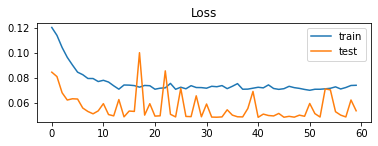

In [6]:
# plot loss during training
plt.subplot(211)
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()

In [7]:
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

In [8]:
# calculate root mean squared error
# trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
# print('Train Score: %.2f RMSE' % (trainScore))
# trainScore = mean_absolute_error(trainY[0], trainPredict[:,0])
# print('Train Score: %.2f MAE' % (trainScore))
# testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
# print('Test Score: %.2f RMSE' % (testScore))
# testScore = mean_absolute_error(testY[0], testPredict[:,0])
# print('Test Score: %.2f MAE' % (testScore))


In [9]:
def mda(actual: np.ndarray, predicted: np.ndarray):
    """ Mean Directional Accuracy """
    return np.mean((np.sign(actual[1:] - actual[:-1]) == np.sign(predicted[1:] - actual[:-1])).astype(int))

In [10]:
train_mda = mda(trainY[0], trainPredict[:,0])
test_mda = mda(testY[0], testPredict[:,0])
print('Train Score: %2.2f %% of MDA' % (train_mda*100))
print('Test Score: %2.2f %% of MDA' % (test_mda*100))


Train Score: 68.67 % of MDA
Test Score: 65.77 % of MDA


In [11]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(df_cases)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back-1:len(trainPredict)+look_back-1, :] = trainPredict

In [12]:
# shift test predictions for plotting
testPredictPlot = np.empty_like(df_cases)
testPredictPlot[:, :] = np.nan
testPredictPlot[-len(testPredict)-1:-1, :] = testPredict

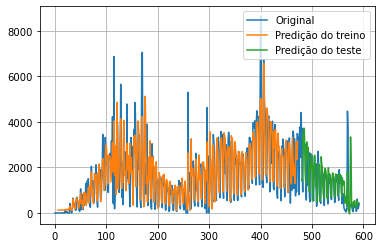

In [13]:
# plot baseline and predictions
plt.plot(scaler.inverse_transform(df_cases), label='Original')
plt.plot(trainPredictPlot , label='Predição do treino')
plt.plot(testPredictPlot, label='Predição do teste')
#plt.plot(scaler.inverse_transform([trainY]), label='?')
plt.grid()
#plt.xlim(300, 330)
#plt.ylim(0, 400)
plt.legend()
plt.show()

<a href='https://www.linkedin.com/pulse/rmse-ou-mae-como-avaliar-meu-modelo-de-machine-learning-rezende/?originalSubdomain=pt'>rmse vs mae</a>